In [1]:
from src import models, utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
%load_ext autoreload
%autoreload 2

2025-02-06 18:34:08.219835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 18:34:08.342916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738863248.394159  188255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738863248.410254  188255 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 18:34:08.538024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# 1. Setup and Data Preparation
- Define dataset paths, frame rate, and neural network configuration. 
- Load pedestrian data for specified situations.

In [2]:
dataset_path = "data/"
situations = ['Bottleneck_Data', 'Corridor_Data']
frame_rate = 1/16

data_loader = utils.data_loader.DataLoader(dataset_path, frame_rate)
data_loader.load_situations(situations)

- Visualize the dataset for each situation.

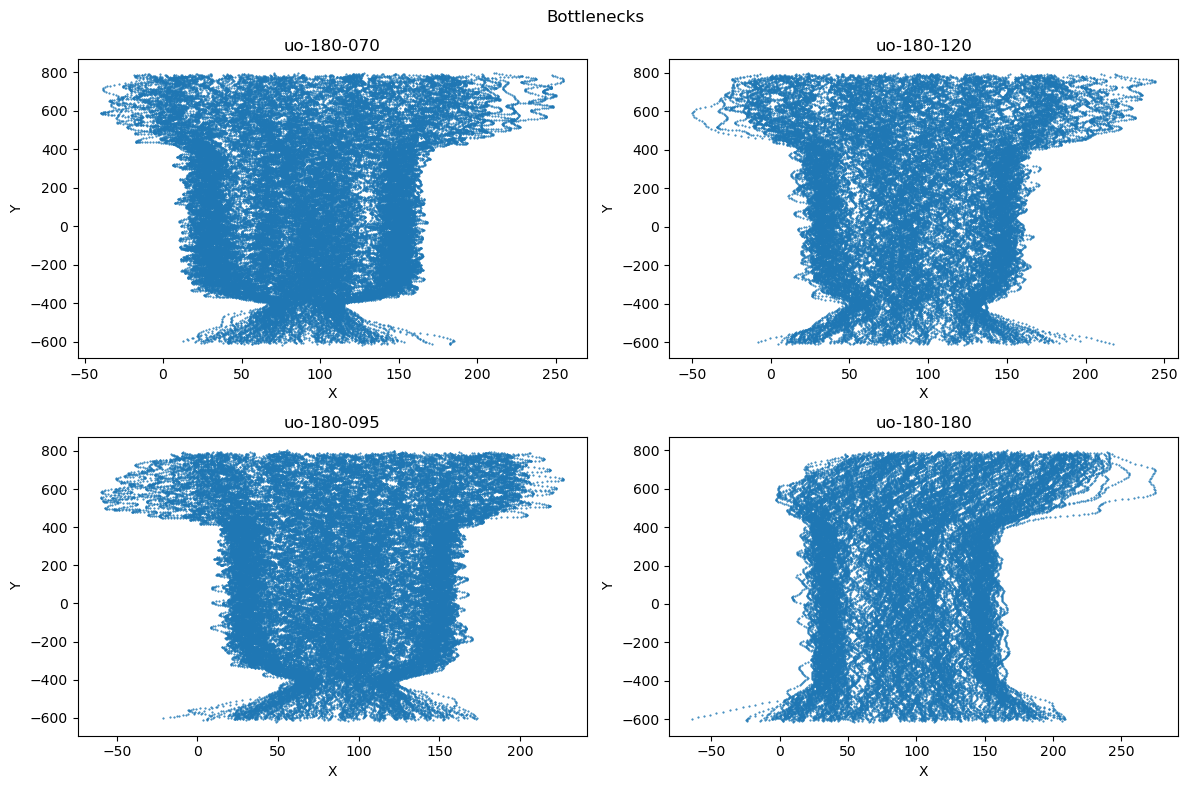

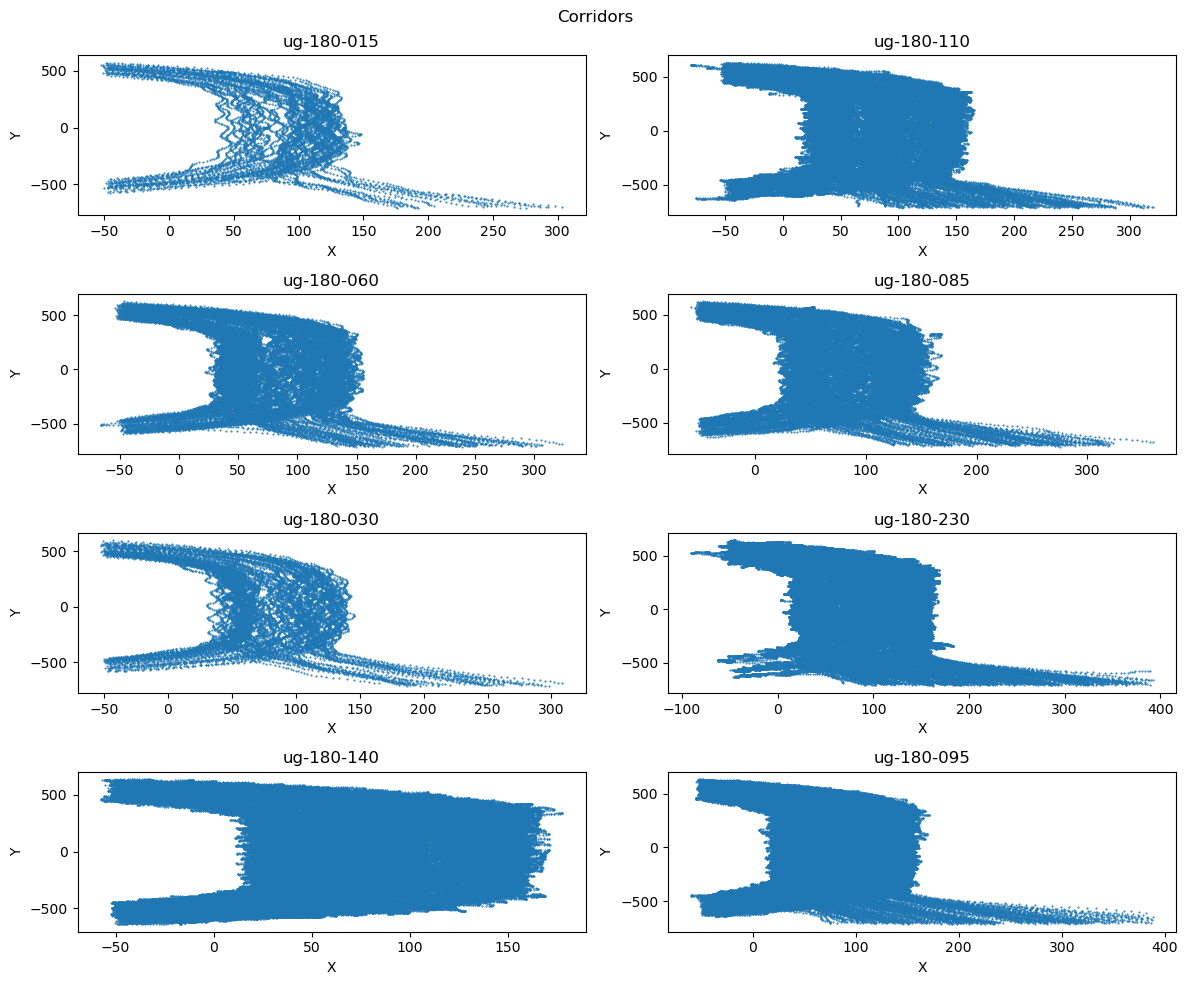

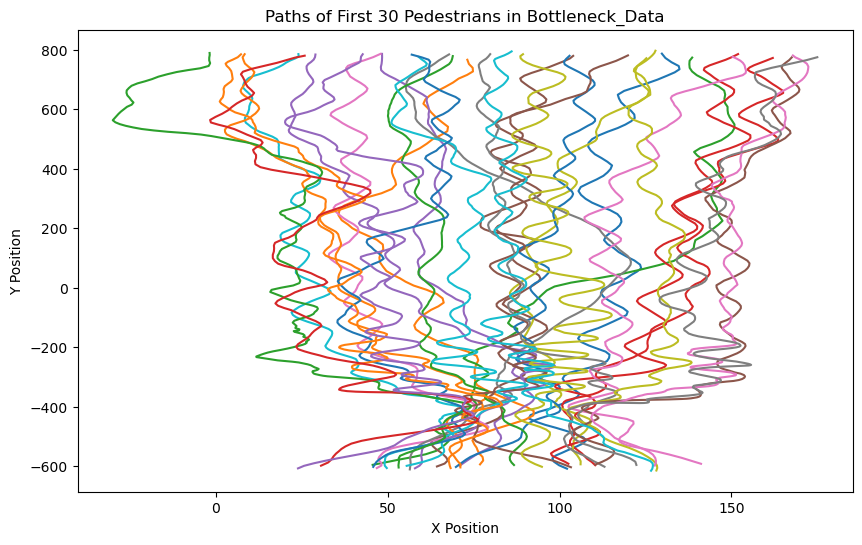

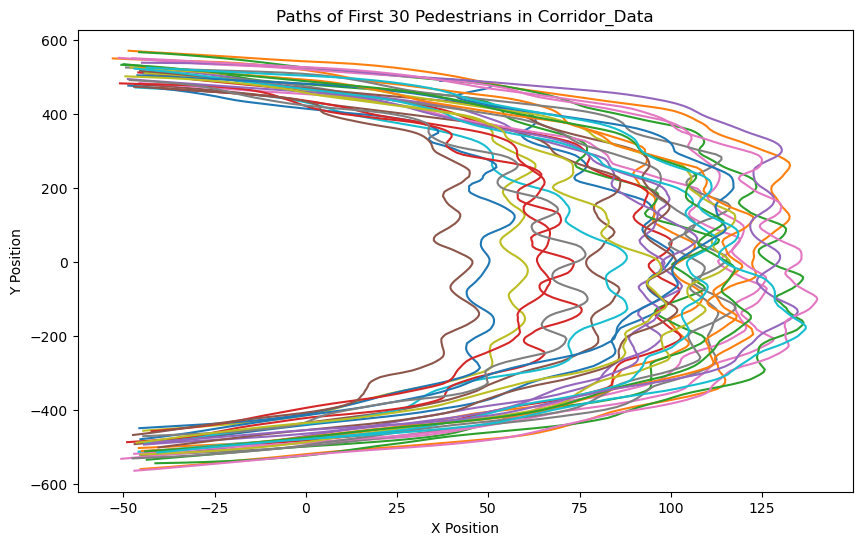

In [3]:
# Visualization - Bottlenecks
bottle_neck = data_loader.get_scenario_data('Bottleneck_Data')
bottle_neck_keys = list(bottle_neck.keys())
utils.visualization.plot_bottlenecks(bottle_neck, bottle_neck_keys)

# Visualization - Corridors
corridor = data_loader.get_scenario_data('Corridor_Data')
corridor_keys = list(corridor.keys())
utils.visualization.plot_corridors(corridor, corridor_keys)

# Plot paths for first 30 pedestrians - Bottleneck
utils.visualization.plot_paths_bottleneck(data_loader.data, bottle_neck_keys)

# Plot paths for first 30 pedestrians - Corridor
utils.visualization.plot_paths_corridor(data_loader.data, corridor_keys)

# 2. Data Analysis
- Analyze a sample dataset and calculate mean spacings.
- Calculate mean spacings.

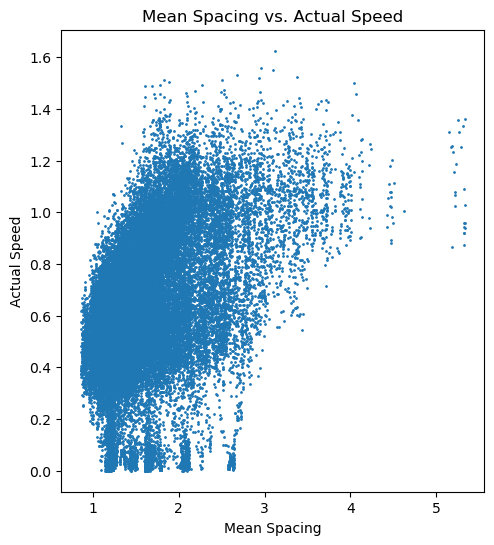

In [4]:
selected_situation = data_loader.get_situation_data('Corridor_Data', 'ug-180-085')

weidmann = models.modeling.WeidmannModel()

mean_spacings, updated_data, neighbors = weidmann.calculate_mean_spacing(selected_situation, k=10, three_d=False)
agent_speeds = weidmann.compute_agent_speeds(updated_data, frame_rate)

utils.visualization.plot_mean_spacing_vs_speed(mean_spacings, agent_speeds)

- Predict speeds and calculate MSE using Weidmann model with example parameters.

In [5]:
v0, t, l_size = 0.95, 1.25, 0.95
mse, predicted_speeds = weidmann.calculate_weidmann_mse(mean_spacings, agent_speeds, v0, t, l_size)
print(f"Mean Squared Error (MSE) between actual and predicted speeds: {mse:.4f}")

Mean Squared Error (MSE) between actual and predicted speeds: 0.1268


- Prepare data for neural network training.

In [6]:
neural = models.modeling.NeuralNetworkModel()
input_data, output_data = neural.prepare_training_data(agent_speeds, mean_spacings, neighbors)

- Normalize the data.
- Split the data into training and testing sets.

In [7]:
normalized_input_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

X_train, X_test, y_train, y_test = train_test_split(normalized_input_data, output_data, test_size=0.5, random_state=42)

# 3. Neural Network Modeling and Training
- Create and train the neural network model.

In [8]:
input_dim = X_train.shape[1]
output_dim = 1
nn_hidden_layers = [3]

nn_model = neural.create_nn_model(input_dim, output_dim, nn_hidden_layers)

train_loss, val_loss, test_loss = neural.perform_bootstrapping(nn_model, X_train, y_train, X_test, y_test, bootstrap_samples=50, bootstrap_size=100, k_folds=5, epochs=30, batch_size=32)

2025-02-06 18:38:20.139605: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.2436 - val_loss: 0.2386
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2520 - val_loss: 0.2320
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2350 - val_loss: 0.2255
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2419 - val_loss: 0.2190
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2387 - val_loss: 0.2128
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2343 - val_loss: 0.2067
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2120 - val_loss: 0.2007
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2042 - val_loss: 0.1949
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2039 - val_loss: 0.1892
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2119 - val_loss: 0.1836
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1858 - val_loss: 0.1783
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1827 - val_loss: 0.1730


KeyboardInterrupt: 

- Visualize training and validation loss.

In [ ]:
print(f"Bootstrapping Training Loss: {train_loss[0]}")
print(f"Bootstrapping Validation Loss: {val_loss[0]}")
print(f"Bootstrapping Test Loss: {test_loss[0]}")

Bootstrapping Training Loss: 0.04493336141109467
Bootstrapping Validation Loss: 0.055049478113651275
Bootstrapping Test Loss: 0.08864004498293929


- Evaluate the model on the test set.
- Predict using the trained model.

In [11]:
test_loss = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

predictions = nn_model.predict(X_test)
print(f"Predictions: {predictions[:5]}")  # Displaying first 5 predictions

828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0402
Test Loss: 0.040685251355171204
828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step
Predictions: [[0.47539175]
 [0.4029969 ]
 [0.5070894 ]
 [1.1233538 ]
 [0.65052086]]


# 4. Neural Network and FD Model on Data Combinations

In [8]:
# Define scenarios
bottleneck_scenario = "uo-180-070"
corridor_scenario = "ug-180-085"

# Weidmann model parameters
weidmann_params = {
    "Corridor_Data": {"v0": 1.44, "t": 0.68, "l_size": 0.63},
    "Bottleneck_Data": {"v0": 1.51, "t": 0.50, "l_size": 0.66},
}

# Define training/testing scenario combinations
training_combinations = [
    ([("Corridor_Data", corridor_scenario)], [("Corridor_Data", corridor_scenario)]),
    ([("Bottleneck_Data", bottleneck_scenario)], [("Bottleneck_Data", bottleneck_scenario)]),
    ([("Corridor_Data", corridor_scenario)], [("Bottleneck_Data", bottleneck_scenario)]),
    ([("Bottleneck_Data", bottleneck_scenario)], [("Corridor_Data", corridor_scenario)]),
    ([("Corridor_Data", corridor_scenario), ("Bottleneck_Data", bottleneck_scenario)], [("Corridor_Data", corridor_scenario)]),
    ([("Corridor_Data", corridor_scenario), ("Bottleneck_Data", bottleneck_scenario)], [("Bottleneck_Data", bottleneck_scenario)]),
    ([("Corridor_Data", corridor_scenario), ("Bottleneck_Data", bottleneck_scenario)], [("Corridor_Data", corridor_scenario), ("Bottleneck_Data", bottleneck_scenario)]),
]

In [11]:
nn_total_losses = {}
weidmann_total_losses = {}

for train_situations, test_situations in training_combinations:
    print(f"\nTraining on {train_situations} and testing on {test_situations}")

    X_train_list, y_train_list = [], []

    # Process each training scenario individually
    for scenario_name, situation_name in train_situations:
        # Load scenario data
        situation_data = data_loader.get_situation_data(scenario_name, situation_name)
        
        # Compute mean spacings and agent speeds
        mean_spacings, updated_trajectories, neighbor_data = weidmann.calculate_mean_spacing(situation_data, k=10, three_d=False)
        agent_speeds = weidmann.compute_agent_speeds(updated_trajectories, frame_rate)

        # Prepare input (X) and output (y) data
        X_train_scenario, y_train_scenario = neural.prepare_training_data(agent_speeds, mean_spacings, neighbor_data)

        # Standardize input data
        X_train_scenario = (X_train_scenario - np.mean(X_train_scenario, axis=0)) / np.std(X_train_scenario, axis=0)

        # Store results
        X_train_list.append(X_train_scenario)
        y_train_list.append(y_train_scenario)

    # Merge processed training data
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)

    # --- Process Test Data in the Same Way ---
    X_test_list, y_test_list = [], []
    weidmann_losses = []

    for scenario_name, situation_name in test_situations:
        # Load test scenario data
        situation_data = data_loader.get_situation_data(scenario_name, situation_name)
        
        # Compute mean spacings and agent speeds
        mean_spacings, updated_trajectories, neighbor_data = weidmann.calculate_mean_spacing(situation_data, k=10, three_d=False)
        agent_speeds = weidmann.compute_agent_speeds(updated_trajectories, frame_rate)

        # Prepare input (X) and output (y) data
        X_test_scenario, y_test_scenario = neural.prepare_training_data(agent_speeds, mean_spacings, neighbor_data)

        # Standardize input data
        X_test_scenario = (X_test_scenario - np.mean(X_test_scenario, axis=0)) / np.std(X_test_scenario, axis=0)

        # Store results
        X_test_list.append(X_test_scenario)
        y_test_list.append(y_test_scenario)

        # Use the corresponding Weidmann parameters for the test scenario
        params = weidmann_params[scenario_name]
        temp_weidmann_mse, _ = weidmann.calculate_weidmann_mse(mean_spacings, agent_speeds, params["v0"], params["t"], params["l_size"])
        weidmann_losses.append(temp_weidmann_mse)

    # Merge processed test data
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    # Train Neural Network
    input_dim = X_train.shape[1]
    nn_model = neural.create_nn_model(input_dim, 1, [3])

    train_loss, val_loss, test_loss = neural.perform_bootstrapping(
        nn_model, X_train, y_train, X_test, y_test, bootstrap_samples=50, bootstrap_size=100, k_folds=5, epochs=30, batch_size=32
    )

    # Store losses
    config_name = f"{'+'.join(t[0][0] for t in train_situations)}/{'+'.join(t[0][0] for t in test_situations)}"
    nn_total_losses[config_name] = test_loss[0]
    weidmann_loss = np.mean(weidmann_losses)
    weidmann_total_losses[config_name] = weidmann_loss


Training on [('Corridor_Data', 'ug-180-085')] and testing on [('Corridor_Data', 'ug-180-085')]
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 1.0352 - val_loss: 1.1994
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0672 - val_loss: 1.1813
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0185 - val_loss: 1.1634
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9780 - val_loss: 1.1449
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0018 - val_loss: 1.1269
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9962 - val_loss: 1.1090
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9507 - val_loss: 1.0918
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9305 - val_loss: 1.0743
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9058 - val_loss: 1.0570
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9119 - val_loss: 1.0403
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8842 - val_l

/tmp/ipykernel_27202/3021089016.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(configs, rotation=45, ha="right")


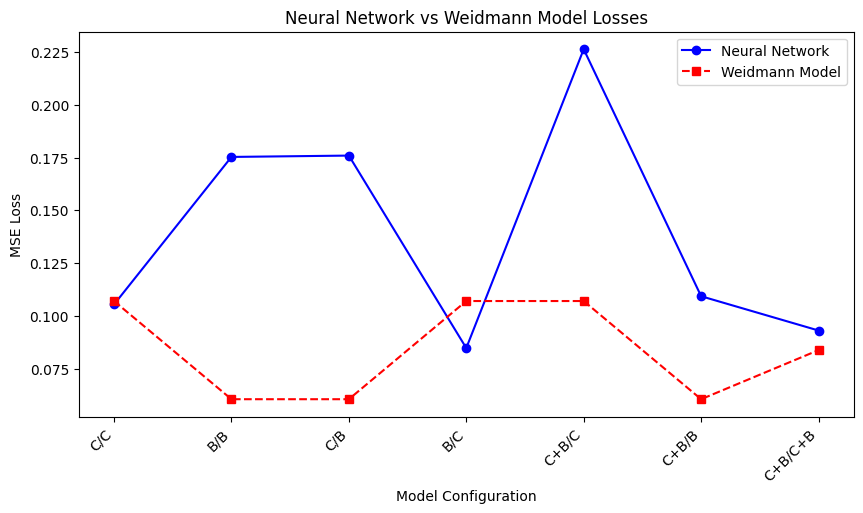

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

configs = list(nn_total_losses.keys())
nn_losses = list(nn_total_losses.values())
weidmann_losses = [weidmann_total_losses[config] for config in configs]

ax.plot(configs, nn_losses, label="Neural Network", marker='o', linestyle='-', color='blue')
ax.plot(configs, weidmann_losses, label="Weidmann Model", marker='s', linestyle='--', color='red')

ax.set_ylabel("MSE Loss")
ax.set_xlabel("Model Configuration")
ax.set_xticklabels(configs, rotation=45, ha="right")
ax.set_title("Neural Network vs Weidmann Model Losses")
ax.legend()

plt.show()